In [1]:
library(Matrix)
library(tidyverse)
library(ggpointdensity)
library(scico)
library(scales)
library(purrr)
library(DoubletFinder)
library(DropletUtils)
library(ggplot2)
library(patchwork)
library(scDblFinder)
library(SingleCellExperiment)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attachi

In [2]:
outdir <- "/mnt/data1/10XvParse/Analysis_3/"
methods <- c('10x','polyT', 'randO', 'parse')
modified <- c(FALSE, FALSE, FALSE, TRUE)
samples <- c('H1', 'H2')
expected_doublet_rate = c(0.076, 0.003, 0.003, 0.003)

In [3]:
get_mat_dir <- function(type, outdir) {
  # Unpack type values
  method <- type[[1]]
  sample <- type[[2]]
  modified <- type[[3]]

  # Generate Path
  m_string <- ifelse(modified, "_modified", "")
  dir <- paste0(outdir, "sample_", method, "_", sample, "_out/") |>
         paste0("counts_unfiltered", m_string, "/")
  
  return(dir)
}

read_count_output <- function(dir) {
  dir <- normalizePath(dir, mustWork = TRUE)
  name <- "cells_x_genes"
  m <- readMM(paste0(dir, "/", name, ".mtx")) |>
       Matrix::t() |> 
       as("CsparseMatrix")
  # The matrix read has cells in rows
  ge <- ".genes.txt"
  genes <- readLines(file(paste0(dir, "/", name, ".genes.txt")))
  barcodes <- readLines(file(paste0(dir, "/", name, ".barcodes.txt")))
  colnames(m) <- barcodes
  rownames(m) <- genes
  return(m) 
}

In [4]:
get_mats <- function(type, outdir){
  m <- get_mat_dir(type, outdir) |>
       read_count_output()
  return(m)
}

knee_plot <- function(bc_rank, cutoff = NULL) {
  knee_plt <- tibble(rank = bc_rank[["rank"]],
                     total = bc_rank[["total"]]) %>%
    distinct() %>%
    dplyr::filter(total > 0)

  ifelse(is.null(cutoff),
    annot <- tibble(
      inflection = metadata(bc_rank)[["inflection"]],
      rank_cutoff = max(bc_rank$rank[bc_rank$total > metadata(bc_rank)[["inflection"]]])),
    annot <- tibble(
      inflection = cutoff,
      rank_cutoff = max(bc_rank$rank[bc_rank$total > cutoff])
    )
  )
                
  p <- ggplot(knee_plt, aes(total, rank)) +
    geom_line() +
    geom_hline(aes(yintercept = rank_cutoff), data = annot, linetype = 2) +
    geom_vline(aes(xintercept = inflection), data = annot, linetype = 2) +
    scale_x_log10() +
    scale_y_log10() +
    annotation_logticks() +
    labs(y = "Rank", x = "Total UMIs")
  return(p)
}

filter_mats <- function(m, bc_rank){
  tot_counts <- Matrix::colSums(m)
  m <- m[, tot_counts > metadata(bc_rank)$inflection]
  m <- m[Matrix::rowSums(m) > 0,]
  return(m)
}

In [5]:
generate_sample_df <- function(methods, samples, modified){
    combos <- expand.grid(methods, samples,
                          KEEP.OUT.ATTRS = FALSE, 
                          stringsAsFactors = FALSE)
    colnames(combos) <- c("method", "sample")
    combos$modified <- modified
    combos$full_name <- paste(combos$method, combos$sample, sep="_")
    return(combos)
}

In [6]:
sample_df = generate_sample_df(methods, samples, modified)
sample_df

method,sample,modified,full_name
<chr>,<chr>,<lgl>,<chr>
10x,H1,FALSE,10x_H1
polyT,H1,FALSE,polyT_H1
randO,H1,FALSE,randO_H1
parse,H1,TRUE,parse_H1
10x,H2,FALSE,10x_H2
polyT,H2,FALSE,polyT_H2
randO,H2,FALSE,randO_H2
parse,H2,TRUE,parse_H2


In [7]:
mats <- apply(sample_df, 1, \(s) get_mats(s, outdir))
bc_ranks <- map(mats, \(m) barcodeRanks(m, lower=10))

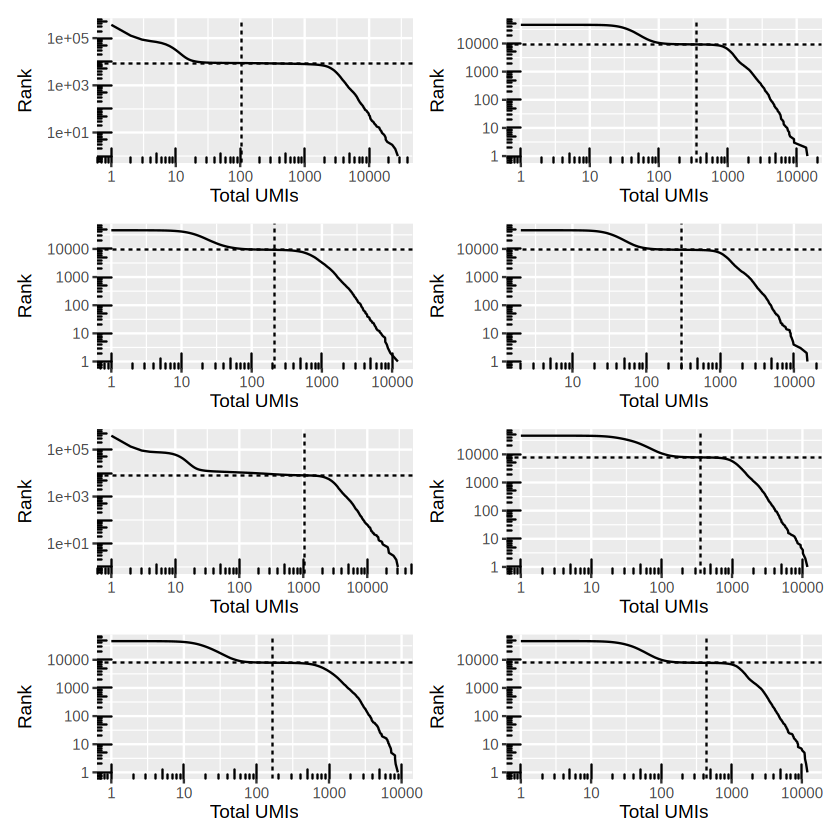

In [ ]:
plots <- map(bc_ranks, knee_plot)
wrap_plots(plots, ncol=2)

In [13]:
mats <- map2(mats, bc_ranks, filter_mats)

In [19]:
generate_SCE <- function(m, name){
    sce <- SingleCellExperiment(list(counts=m), mainExpName=name)
    return(sce)
}

In [28]:
sces <- map2(mats, sample_df$full_name, generate_SCE)

In [31]:
sces <- map(sces, scDblFinder)

Warning message in .checkSCE(sce, coerce = is.null(samples)):
“Some cells in `sce` have an extremely low read counts; note that these could trigger errors and might best be filtered out”
Creating ~7046 artificial doublets...

Dimensional reduction

Evaluating kNN...

Training model...

iter=0, 1267 cells excluded from training.

Warning message in check.deprecation(deprecated_cv_params, match.call(), ...):
“Passed invalid function arguments: max_depth, eval_metric, tree_method, subsample, nthread, eta. These should be passed as a list to argument 'params'. Conversion from argument to 'params' entry will be done automatically, but this behavior will become an error in a future version.”
Warning message in throw_err_or_depr_msg("Parameter(s) have been removed from this function: ", :
“Parameter(s) have been removed from this function: label. This warning will become an error in a future version.”
iter=1, 1267 cells excluded from training.

Warning message in check.deprecation(deprecated_

In [51]:
get_cell_num <- function(sce){
    cell_num <- length(sce$scDblFinder.class)
    return(cell_num)
}

get_db_num <- function(sce){
    db_num <- sum(sce$scDblFinder.class == 'doublet')
    return(db_num)
}

db_nums <- map(sces, get_db_num)
cell_nums <- map(sces, get_cell_num)

In [63]:
sample_df$db_num <- as.numeric(db_nums)
sample_df$cell_num <- as.numeric(cell_nums)
sample_df$db_percent <- sample_df$db_num / sample_df$cell_num *100
sample_df

method,sample,modified,full_name,db_num,cell_num,db_percent
<chr>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>
10x,H1,FALSE,10x_H1,863,8807,9.799024
polyT,H1,FALSE,polyT_H1,1085,9287,11.682998
randO,H1,FALSE,randO_H1,1092,9325,11.710456
parse,H1,TRUE,parse_H1,1070,9350,11.443850
10x,H2,FALSE,10x_H2,729,8003,9.109084
polyT,H2,FALSE,polyT_H2,798,7804,10.225525
randO,H2,FALSE,randO_H2,764,7894,9.678237
parse,H2,TRUE,parse_H2,841,7792,10.793121


In [64]:
combined_df <- sample_df |> 
               group_by(method) |> 
               summarize(
                 cell_num = sum(cell_num),
                 db_num = sum(db_num))
combined_df$db_percent <- combined_df$db_num / combined_df$cell_num * 100
combined_df

method,cell_num,db_num,db_percent
<chr>,<dbl>,<dbl>,<dbl>
10x,16810,1592,9.470553
parse,17142,1911,11.148057
polyT,17091,1883,11.017495
randO,17219,1856,10.778791


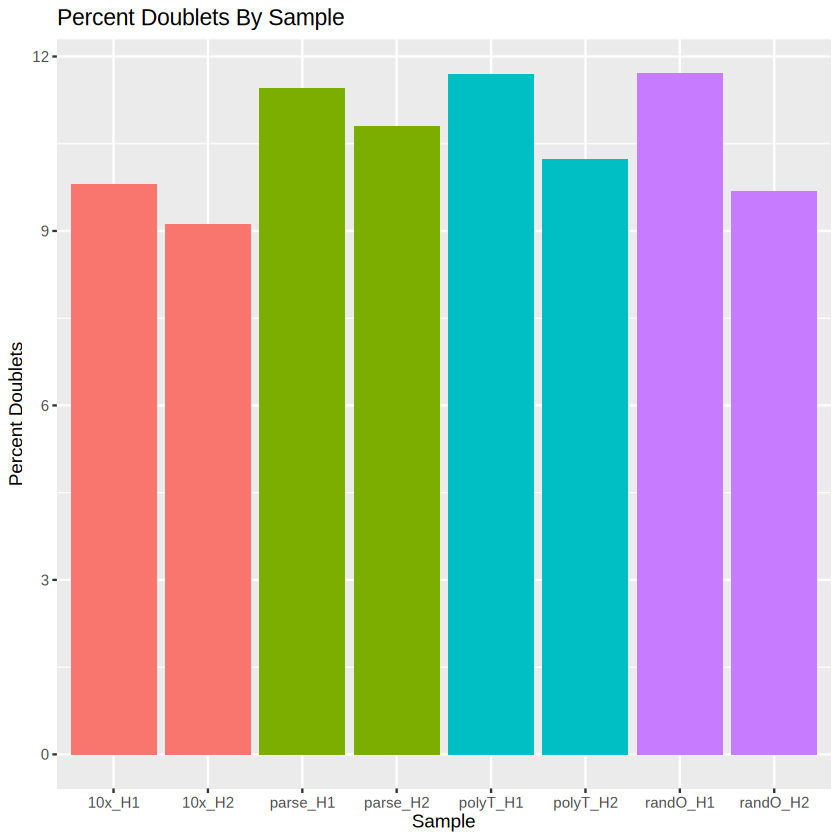

In [72]:
ggplot(sample_df, aes(x = full_name, y = db_percent, fill = method)) + 
    geom_bar(stat = "identity") + 
    labs(
        title = "Percent Doublets By Sample",
        x = "Sample", y = "Percent Doublets") + 
    theme(legend.position = "none")

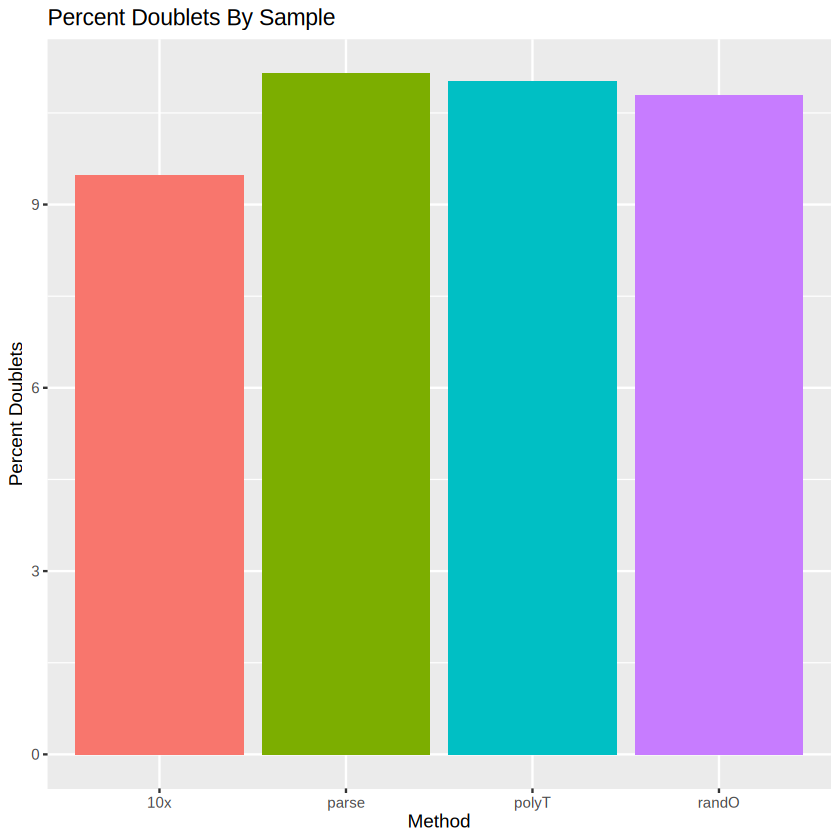

In [73]:
ggplot(combined_df, aes(x = method, y = db_percent, fill = method)) + 
    geom_bar(stat = "identity") + 
    labs(
        title = "Percent Doublets By Sample",
        x = "Method", y = "Percent Doublets") + 
    theme(legend.position = "none")